# Import the relevant packages

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Load the NYC Taxi Fares datasets
The dataset is just 120,000 records from April 11 to April 24, 2010, rather than the original 55 million records

In [2]:
df = pd.read_csv("NYCTaxiFares.csv")
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1


In [3]:
df["fare_amount"].describe()

count    120000.000000
mean         10.040326
std           7.500134
min           2.500000
25%           5.700000
50%           7.700000
75%          11.300000
max          49.900000
Name: fare_amount, dtype: float64

# Feature engineering - calculate distance traveled
Since the pickup_longitude and pick_latitude could not tell much useful information, we use the haversine formula to calculate the distance between two sets of GPS coordinates

${\displaystyle d=2r\arcsin \left({\sqrt {\sin ^{2}\left({\frac {\varphi _{2}-\varphi _{1}}{2}}\right)+\cos(\varphi _{1})\:\cos(\varphi _{2})\:\sin ^{2}\left({\frac {\lambda _{2}-\lambda _{1}}{2}}\right)}}\right)}$

where

$\begin{split} r&: \textrm {radius of the sphere (Earth's radius averages 6371 km)}\\
\varphi_1, \varphi_2&: \textrm {latitudes of point 1 and point 2}\\
\lambda_1, \lambda_2&: \textrm {longitudes of point 1 and point 2}\end{split}$

In [4]:
def haversine_distance(df, lat1, long1, lat2, long2):
    """
    Calculates the haversine distance between 2 sets of GPS coordinates in df
    """
    r = 6371  # average radius of Earth in kilometers
       
    phi1 = np.radians(df[lat1])
    phi2 = np.radians(df[lat2])
    
    delta_phi = np.radians(df[lat2]-df[lat1])
    delta_lambda = np.radians(df[long2]-df[long1])
     
    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = (r * c) # in kilometers

    return d

In [5]:
df['dist_km'] = haversine_distance(df,'pickup_latitude', 
                                   'pickup_longitude', 
                                   'dropoff_latitude', 
                                   'dropoff_longitude')
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321


# Feature engineering - add datetime column

In [6]:
#The data was saved in UTC time and the data also fall in Daylight Savings Time in NYC. So, the EDT is UTC - 4
#pd.Timedelta Represents a duration, the difference between two dates or times
df['EDTdate'] = pd.to_datetime(df['pickup_datetime'].str[:19]) - pd.Timedelta(hours=4)
df['Hour'] = df['EDTdate'].dt.hour
df['AMorPM'] = np.where(df['Hour']<12,'am','pm')
df['Weekday'] = df['EDTdate'].dt.strftime("%a")
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km,EDTdate,Hour,AMorPM,Weekday
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312,2010-04-19 04:17:56,4,am,Mon
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307,2010-04-17 11:43:53,11,am,Sat
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763,2010-04-17 07:23:26,7,am,Sat
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129,2010-04-11 17:25:03,17,pm,Sun
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321,2010-04-16 22:19:01,22,pm,Fri


# Separate categorical from continuous columns

In [7]:
df.columns

Index(['pickup_datetime', 'fare_amount', 'fare_class', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'dist_km', 'EDTdate', 'Hour', 'AMorPM', 'Weekday'],
      dtype='object')

In [8]:
cat_cols = ['Hour', 'AMorPM', 'Weekday']
cont_cols = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'passenger_count', 'dist_km']
y_col = ['fare_amount']  # target labels

# Categorify

In [9]:
df.dtypes

pickup_datetime              object
fare_amount                 float64
fare_class                    int64
pickup_longitude            float64
pickup_latitude             float64
dropoff_longitude           float64
dropoff_latitude            float64
passenger_count               int64
dist_km                     float64
EDTdate              datetime64[ns]
Hour                          int64
AMorPM                       object
Weekday                      object
dtype: object

In [10]:
# Convert our three categorical columns to category dtypes.
for cat in cat_cols:
    df[cat] = df[cat].astype('category')

In [11]:
df.dtypes

pickup_datetime              object
fare_amount                 float64
fare_class                    int64
pickup_longitude            float64
pickup_latitude             float64
dropoff_longitude           float64
dropoff_latitude            float64
passenger_count               int64
dist_km                     float64
EDTdate              datetime64[ns]
Hour                       category
AMorPM                     category
Weekday                    category
dtype: object

In [12]:
df['Hour'].head()

0     4
1    11
2     7
3    17
4    22
Name: Hour, dtype: category
Categories (24, int64): [0, 1, 2, 3, ..., 20, 21, 22, 23]

In [13]:
df['Weekday'].cat.categories

Index(['Fri', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed'], dtype='object')

In [14]:
df['Weekday'].head().cat.codes

0    1
1    2
2    2
3    3
4    0
dtype: int8

combine the three categorical columns into one array by numpy.stack

In [15]:
hr = df['Hour'].cat.codes.values
ampm = df['AMorPM'].cat.codes.values
wkdy = df['Weekday'].cat.codes.values

cats = np.stack([hr, ampm, wkdy], 1)

cats[:5]

array([[ 4,  0,  1],
       [11,  0,  2],
       [ 7,  0,  2],
       [17,  1,  3],
       [22,  1,  0]], dtype=int8)

# Convert numpy arrays to tensors

In [16]:
#categorical variables to a tensor
cats = torch.tensor(cats, dtype=torch.int64) 
cats[:5]

tensor([[ 4,  0,  1],
        [11,  0,  2],
        [ 7,  0,  2],
        [17,  1,  3],
        [22,  1,  0]])

In [17]:
#convert continuous variables into a tensor
conts = np.stack([df[col].values for col in cont_cols], 1)
conts = torch.tensor(conts, dtype=torch.float)
conts[:5]

tensor([[ 40.7305, -73.9924,  40.7447, -73.9755,   1.0000,   2.1263],
        [ 40.7406, -73.9901,  40.7441, -73.9742,   1.0000,   1.3923],
        [ 40.7511, -73.9941,  40.7662, -73.9601,   2.0000,   3.3268],
        [ 40.7564, -73.9905,  40.7482, -73.9712,   1.0000,   1.8641],
        [ 40.7342, -73.9910,  40.7431, -73.9060,   1.0000,   7.2313]])

In [18]:
#conver the labels to a tensor
y = torch.tensor(df[y_col].values, dtype=torch.float).reshape(-1,1)
y[:5]

tensor([[ 6.5000],
        [ 6.9000],
        [10.1000],
        [ 8.9000],
        [19.7000]])

# Set the embedding size

In [19]:
#The embedding sizes for hours, Am/PM and Weekdays
cat_szs = [len(df[col].cat.categories) for col in cat_cols]
emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs]
emb_szs

[(24, 12), (2, 1), (7, 4)]

# Define the model

In [20]:
class TabularModel(nn.Module):
    # extend the base Module class, set up the parameters
    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        # emb_szs: list of tuples, each categorical size is paired with an embedding size
        # n_count: number of continuous variables
        # out_sz: output size
        # layers: layer_sizes
        # p: dropout
        super().__init__()
        # categorical data will be filtered through the embeddings in the forward section
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        # set up a dropout function for the embedding
        self.emb_drop = nn.Dropout(p)
        # set up normalization for continuous variables
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        layerlist = []
        n_emb = sum((nf for ni,nf in emb_szs))
        n_in = n_emb + n_cont
        # Set up a sequence of neural network layers where each level 
        # includes a Linear function, an activation function, 
        # a normalization step, and a dropout layer. 
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))
            
        self.layers = nn.Sequential(*layerlist)
    
    def forward(self, x_cat, x_cont):
        # Define the forward method. 
        # Preprocess the embeddings and normalize the continuous variables 
        # efore passing them through the layers.
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        # concatenate the embedding sections into one
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        x = self.layers(x)
        return x

In [21]:
torch.manual_seed(33)
model = TabularModel(emb_szs, conts.shape[1], 1, [200,100], p=0.4)

In [22]:
model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=1, bias=True)
  )
)

# Define loss function & optimizer 

In [23]:
criterion = nn.MSELoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Perform train/test splits

In [24]:
batch_size = 60000
test_size = int(batch_size * .2)

cat_train = cats[:batch_size-test_size]
cat_test = cats[batch_size-test_size:batch_size]
con_train = conts[:batch_size-test_size]
con_test = conts[batch_size-test_size:batch_size]
y_train = y[:batch_size-test_size]
y_test = y[batch_size-test_size:batch_size]

In [25]:
len(cat_train)

48000

In [26]:
len(cat_test)

12000

# Train the model

In [27]:
import time
start_time = time.time()

epochs = 300
losses = []

for i in range(epochs):
    i+=1
    y_pred = model(cat_train, con_train)
    loss = torch.sqrt(criterion(y_pred, y_train)) # RMSE
    losses.append(loss)
    
    # a neat trick to save screen space:
    if i%25 == 1:
        print(f'epoch: {i:3}  loss: {loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(f'epoch: {i:3}  loss: {loss.item():10.8f}') # print the last line
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:   1  loss: 12.56902599
epoch:  26  loss: 10.90550900
epoch:  51  loss: 10.22915077
epoch:  76  loss: 9.74723625
epoch: 101  loss: 9.19714165
epoch: 126  loss: 8.42077541
epoch: 151  loss: 7.40445518
epoch: 176  loss: 6.24154043
epoch: 201  loss: 5.04088020
epoch: 226  loss: 4.22866917
epoch: 251  loss: 3.88550162
epoch: 276  loss: 3.75429368
epoch: 300  loss: 3.72180653

Duration: 88 seconds


# Plot the loss function

In [29]:
losses = [loss.detach().numpy() for loss in losses]

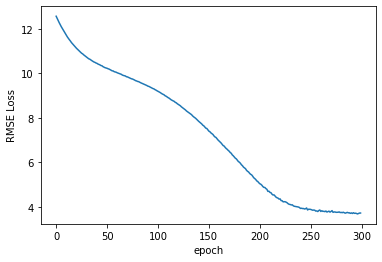

In [30]:
plt.plot(range(epochs), losses)
plt.ylabel('RMSE Loss')
plt.xlabel('epoch');

# Validate the model

In [31]:
with torch.no_grad():
    y_val = model(cat_test, con_test)
    loss = torch.sqrt(criterion(y_val, y_test))
print(f'RMSE: {loss:.8f}')

RMSE: 3.62153411


In [32]:
print(f'{"PREDICTED":>12} {"ACTUAL":>8} {"DIFF":>8}')
for i in range(50):
    diff = np.abs(y_val[i].item()-y_test[i].item())
    print(f'{i+1:2}. {y_val[i].item():8.4f} {y_test[i].item():8.4f} {diff:8.4f}')

   PREDICTED   ACTUAL     DIFF
 1.   4.2644   2.9000   1.3644
 2.  14.4015   5.7000   8.7015
 3.   7.1376   7.7000   0.5624
 4.  14.6971  12.5000   2.1971
 5.   5.7740   4.1000   1.6740
 6.   5.3935   5.3000   0.0935
 7.   4.5794   3.7000   0.8794
 8.  20.2745  14.5000   5.7745
 9.   9.5477   5.7000   3.8477
10.  12.3255  10.1000   2.2255
11.   7.8297   4.5000   3.3297
12.   1.1796   6.1000   4.9204
13.   6.5612   6.9000   0.3388
14.  10.7580  14.1000   3.3420
15.   4.8314   4.5000   0.3314
16.  31.7250  34.1000   2.3750
17.   1.1356  12.5000  11.3644
18.   6.0876   4.1000   1.9876
19.   7.2180   8.5000   1.2820
20.   3.7007   5.3000   1.5993
21.  14.8553  11.3000   3.5553
22.   9.6193  10.5000   0.8807
23.  17.3960  15.3000   2.0960
24.  16.6341  14.9000   1.7341
25.  46.0058  49.5700   3.5642
26.   1.7944   5.3000   3.5056
27.   4.8194   3.7000   1.1194
28.   4.4878   6.5000   2.0122
29.  14.4499  14.1000   0.3499
30.   6.4318   4.9000   1.5318
31.   4.4598   3.7000   0.7598
32.  32.

# Save the model

In [33]:
if len(losses) == epochs:
    torch.save(model.state_dict(), 'TaxiFareRegrModel.pt')
else:
    print('Model has not been trained. Consider loading a trained model instead.')

# Load a saved model

In [34]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd

def haversine_distance(df, lat1, long1, lat2, long2):
    r = 6371
    phi1 = np.radians(df[lat1])
    phi2 = np.radians(df[lat2])
    delta_phi = np.radians(df[lat2]-df[lat1])
    delta_lambda = np.radians(df[long2]-df[long1])
    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return r * c

class TabularModel(nn.Module):
    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        layerlist = []
        n_emb = sum((nf for ni,nf in emb_szs))
        n_in = n_emb + n_cont
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))
        self.layers = nn.Sequential(*layerlist)
    def forward(self, x_cat, x_cont):
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        return self.layers(x)

In [35]:
emb_szs = [(24, 12), (2, 1), (7, 4)]
model2 = TabularModel(emb_szs, 6, 1, [200,100], p=0.4)

In [36]:
model2.load_state_dict(torch.load('TaxiFareRegrModel.pt'));
model2.eval()

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=1, bias=True)
  )
)

In [37]:
def test_data(mdl): # pass in the name of the new model
    # INPUT NEW DATA
    plat = float(input('What is the pickup latitude?  '))
    plong = float(input('What is the pickup longitude? '))
    dlat = float(input('What is the dropoff latitude?  '))
    dlong = float(input('What is the dropoff longitude? '))
    psngr = int(input('How many passengers? '))
    dt = input('What is the pickup date and time?\nFormat as YYYY-MM-DD HH:MM:SS     ')
    
    # PREPROCESS THE DATA
    dfx_dict = {'pickup_latitude':plat,'pickup_longitude':plong,'dropoff_latitude':dlat,
         'dropoff_longitude':dlong,'passenger_count':psngr,'EDTdate':dt}
    dfx = pd.DataFrame(dfx_dict, index=[0])
    dfx['dist_km'] = haversine_distance(dfx,'pickup_latitude', 'pickup_longitude',
                                        'dropoff_latitude', 'dropoff_longitude')
    dfx['EDTdate'] = pd.to_datetime(dfx['EDTdate'])
    
    # We can skip the .astype(category) step since our fields are small,
    # and encode them right away
    dfx['Hour'] = dfx['EDTdate'].dt.hour
    dfx['AMorPM'] = np.where(dfx['Hour']<12,0,1) 
    dfx['Weekday'] = dfx['EDTdate'].dt.strftime("%a")
    dfx['Weekday'] = dfx['Weekday'].replace(['Fri','Mon','Sat','Sun','Thu','Tue','Wed'],
                                            [0,1,2,3,4,5,6]).astype('int64')
    # CREATE CAT AND CONT TENSORS
    cat_cols = ['Hour', 'AMorPM', 'Weekday']
    cont_cols = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude',
                 'dropoff_longitude', 'passenger_count', 'dist_km']
    xcats = np.stack([dfx[col].values for col in cat_cols], 1)
    xcats = torch.tensor(xcats, dtype=torch.int64)
    xconts = np.stack([dfx[col].values for col in cont_cols], 1)
    xconts = torch.tensor(xconts, dtype=torch.float)
    
    # PASS NEW DATA THROUGH THE MODEL WITHOUT PERFORMING A BACKPROP
    with torch.no_grad():
        z = mdl(xcats, xconts)
    print(f'\nThe predicted fare amount is ${z.item():.2f}')

# Feed new data through the trained model

In [38]:
# z = test_data(model2)